In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchvision 
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [35]:
train_dir = './specgrams/TRAIN'
test_dir = './specgrams/TEST'
transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

data batch shape: torch.Size([64, 1, 224, 224])
labels batch shape: torch.Size([64])


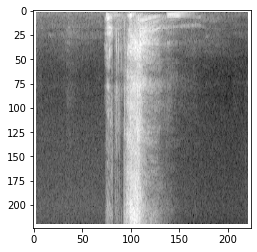

In [36]:
for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    plt.imshow(data_batch[0][0,:,:].numpy(), cmap='gray')
    break

In [34]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()
        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.float().to(device)
            target = target.unsqueeze(-1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            pred = output.round()  # get the prediction
            acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
            train_accuracy.update(acc, n=len(target))
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()
        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.float().to(device)
                target = target.unsqueeze(-1)
                output = model(data)
                loss = loss_fn(output, target)
                val_loss.update(loss.item(), n=len(target))
                pred = output.round()  # get the prediction
                acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
                val_accuracy.update(acc, n=len(target))
                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)
        
    return train_accuracies, train_losses, val_accuracies, val_losses

# Building Network

In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 256, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(256*7*7, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=12544, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=1, bias=True)
  (16): Sigmoid()
)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we choose BCELoss because we have two classes
loss_fn = nn.BCELoss()

In [12]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

[TRAIN] Epoch 1/60:   0%|          | 0/11 [00:00<?, ? batches/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x36864 and 12544x512)